# Consistent Hashing with Binary Search

## Traditional Hashing

In [1]:
import requests

class StorageNode:
    def __init__(self, name=None, host=None):
        self.name = name
        self.host = host
        
    def fetch_file(self, path):
        return requests.get(f'https://{self.host}:1231/{path}').text
    
    def put_file(self, path):
        with open(path, 'r') as fp:
            content = fp.read()
            return requests.post(f'https://{self.host}:1231/{path}', body=content).text

In [2]:
# storage_nodes holding instances of actual storage node objects
storage_nodes = [
    StorageNode(name='A', host='239.67.52.72'),
    StorageNode(name='B', host='137.70.131.229'),
    StorageNode(name='C', host='98.5.87.182'),
    StorageNode(name='D', host='11.225.158.95'),
    StorageNode(name='E', host='203.187.116.210'),
]


def hash_fn(key):
    """The function sums the bytes present in the `key` and then
    take a mod with 5. This hash function thus generates output
    in the range [0, 4].
    """
    return sum(bytearray(key.encode('utf-8'))) % 5

In [3]:
def upload(path):
    # we use the hash function to get the index of the storage node
    # that would hold the file
    index = hash_fn(path)

    # we get the StorageNode instance
    node = storage_nodes[index]

    # we put the file on the node and return
    return node.put_file(path)


def fetch(path):
    # we use the hash function to get the index of the storage node
    # that would hold the file
    index = hash_fn(path)

    # we get the StorageNode instance
    node = storage_nodes[index]

    # we fetch the file from the node and return
    return node.fetch_file(path)

In [4]:
# Now we find where the 5 files 'f1.txt', 'f2.txt', 'f3.txt', 'f4.txt', 'f5.txt'
# reside on the storage nodes.

for file in ['f1.txt', 'f2.txt', 'f3.txt', 'f4.txt', 'f5.txt']:
    print(f"file {file} resides on node {storage_nodes[hash_fn(file)].name}")

file f1.txt resides on node E
file f2.txt resides on node A
file f3.txt resides on node B
file f4.txt resides on node C
file f5.txt resides on node D


### Scaling up the Storage Nodes

Now say we scale up and want to add 2 more storage instances i.e. from 5 we will now have 7 storage nodes, so the hash function instead of doing `mod 5` will now perform `mod 7`.

In [5]:
# storage_nodes holding instances of actual storage node objects
storage_nodes = [
    StorageNode(name='A', host='239.67.52.72'),
    StorageNode(name='B', host='137.70.131.229'),
    StorageNode(name='C', host='98.5.87.182'),
    StorageNode(name='D', host='11.225.158.95'),
    StorageNode(name='E', host='203.187.116.210'),
    StorageNode(name='F', host='107.117.238.203'),
    StorageNode(name='G', host='27.161.219.131'),
]

def hash_fn(key):
    """The function sums the bytes present in the `key` and then
    take a mod with 7. This hash function thus generates output
    in the range [0, 6].
    """
    return sum(bytearray(key.encode('utf-8'))) % 7

In [6]:
# Now we find where the 5 files 'f1.txt', 'f2.txt', 'f3.txt', 'f4.txt', 'f5.txt'
# reside on the storage nodes.

for file in ['f1.txt', 'f2.txt', 'f3.txt', 'f4.txt', 'f5.txt']:
    print(f"file {file} resides on node {storage_nodes[hash_fn(file)].name}")

file f1.txt resides on node D
file f2.txt resides on node E
file f3.txt resides on node F
file f4.txt resides on node G
file f5.txt resides on node A


## Consistent Hashing

In [7]:
import hashlib
from typing import Union
from bisect import bisect, bisect_left, bisect_right

from plot import plot_hashring

In [8]:
def hash_fn(key: str, total_slots: int) -> int:
    """hash_fn creates an integer equivalent of a SHA256 hash and
    takes a modulo with the total number of slots in hash space.
    """
    hsh = hashlib.sha256()

    # converting data into bytes and passing it to hash function
    hsh.update(bytes(key.encode('utf-8')))

    # converting the HEX digest into equivalent integer value
    return int(hsh.hexdigest(), 16) % total_slots

In [9]:
class ConsistentHash:
    """ConsistentHash represents an array based implementation of
    consistent hashing algorithm.
    """

    def __init__(self):
        self._keys = []           # indices taken up in the ring
        self.nodes = []           # nodes present in the ring. nodes[i] is present at index keys[i]
        self.total_slots = 50     # total slots in the ring

    def add_node(self, node: StorageNode) -> int:
        """add_node function adds a new node in the system and returns the key
        from the hash space where it was placed
        """

        # handling error when hash space is full.
        if len(self._keys) == self.total_slots:
            raise Exception("hash space is full")

        key = hash_fn(node.host, self.total_slots)

        # find the index where the key should be inserted in the keys array
        # this will be the index where the Storage Node will be added in the
        # nodes array.
        index = bisect(self._keys, key)

        # if we have already seen the key i.e. node already is present
        # for the same key, we raise Collision Exception
        if index > 0 and self._keys[index - 1] == key:
            raise Exception("collision occurred")

        # insert the node_id and the key at the same `index` location.
        # this insertion will keep nodes and keys sorted w.r.t keys.
        self.nodes.insert(index, node)
        self._keys.insert(index, key)

        return key

    def remove_node(self, node: StorageNode) -> int:
        """remove_node removes the node and returns the key
        from the hash space on which the node was placed.
        """

        # handling error when space is empty
        if len(self._keys) == 0:
            raise Exception("hash space is empty")

        key = hash_fn(node.host, self.total_slots)

        # we find the index where the key would reside in the keys
        index = bisect_left(self._keys, key)

        # if key does not exist in the array we raise Exception
        if index >= len(self._keys) or self._keys[index] != key:
            raise Exception("node does not exist")

        # now that all sanity checks are done we popping the
        # keys and nodes at the index and thus removing presence of the node.
        self._keys.pop(index)
        self.nodes.pop(index)

        return key

    def assign(self, item: str) -> str:
        """Given an item, the function returns the node it is associated with.
        """
        key = hash_fn(item, self.total_slots)

        # we find the first node to the right of this key
        # if bisect_right returns index which is out of bounds then
        # we circle back to the first in the array in a circular fashion.
        index = bisect_right(self._keys, key) % len(self._keys)

        # return the node present at the index
        return self.nodes[index]

    def plot(self, item: str = None, node: StorageNode = None) -> None:
        plot_hashring(
            self.total_slots,
            self._keys,
            self.nodes,
            item_key=hash_fn(item, self.total_slots) if item else None,
            node_key=hash_fn(node.host, self.total_slots) if node else None,
        )

In [10]:
ch = ConsistentHash()

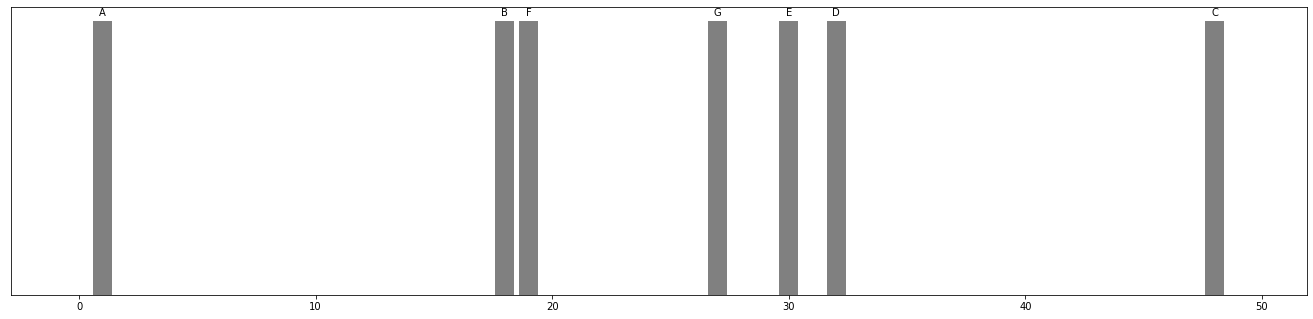

In [11]:
for node in storage_nodes:
    ch.add_node(node)
ch.plot()

file f1.txt (shown in green) resides on node E (shown in red)


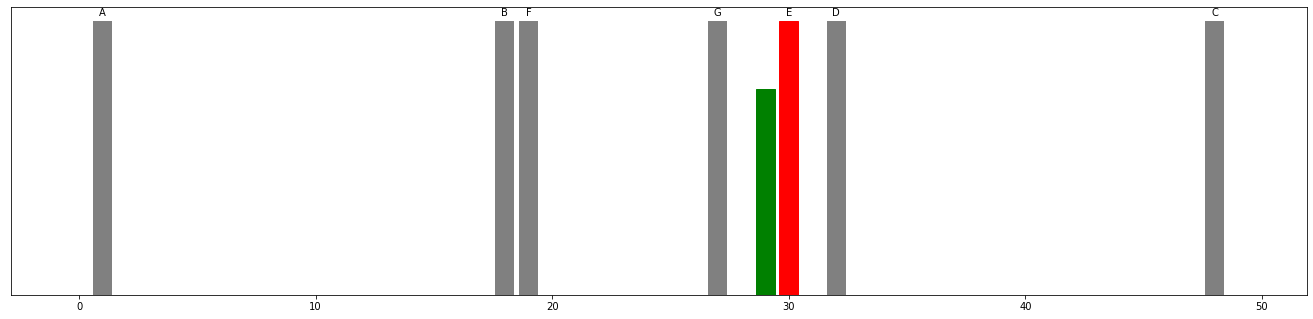

file f2.txt (shown in green) resides on node B (shown in red)


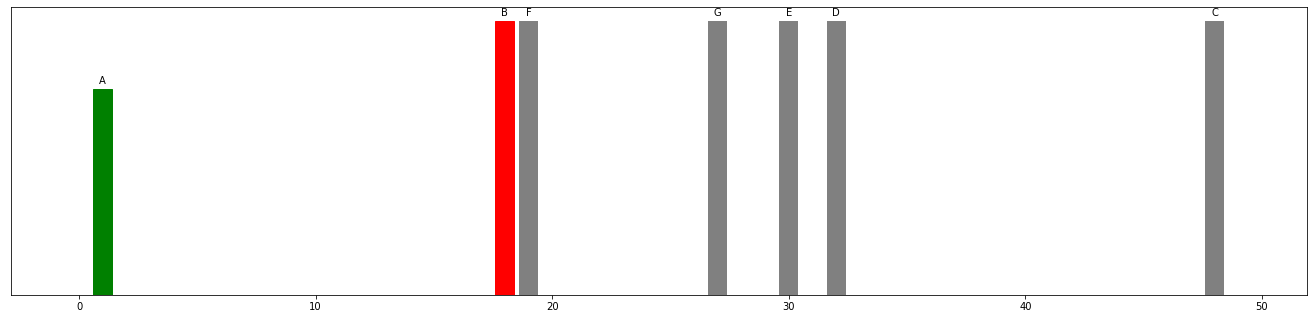

file f3.txt (shown in green) resides on node B (shown in red)


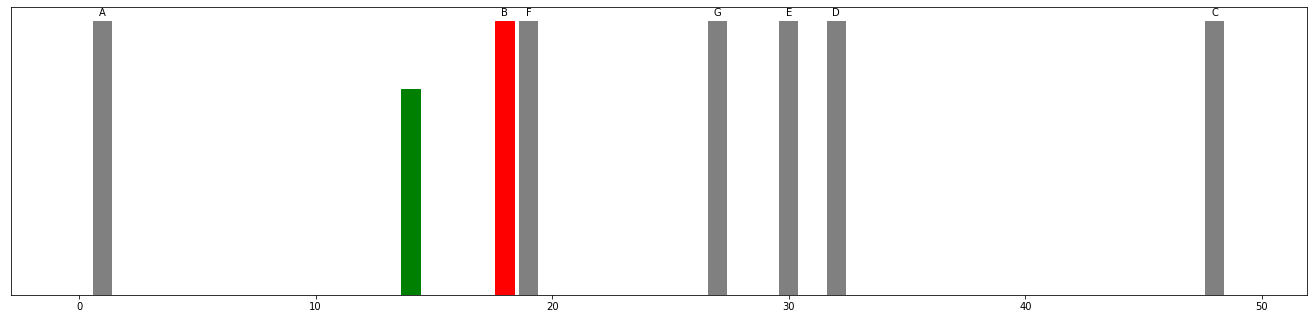

file f4.txt (shown in green) resides on node C (shown in red)


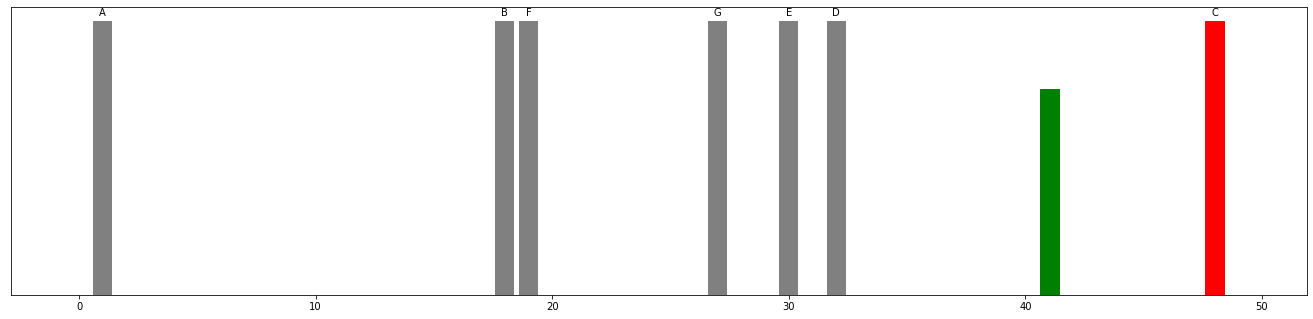

file f5.txt (shown in green) resides on node G (shown in red)


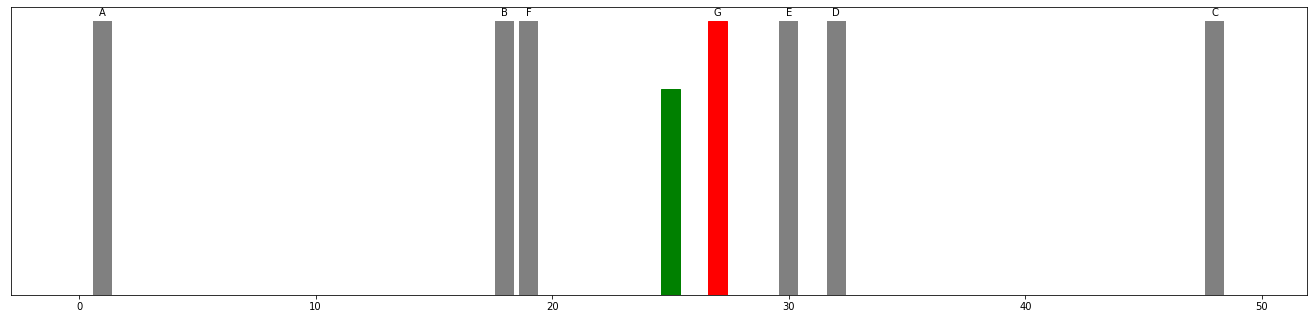

In [12]:
for file in ['f1.txt', 'f2.txt', 'f3.txt', 'f4.txt', 'f5.txt']:
    print(f"file {file} (shown in green) resides on node {ch.assign(file).name} (shown in red)")
    ch.plot(file, ch.assign(file))